In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Use the 'create_ExpData.py' code to generate pseudoraw counts and run limma voom normalisation to
get normalised counts.

In [3]:
# read the normalised expression data
pdx_exp = pd.read_csv('/home/sreeramp/cancer_dependency_project/sreeram/PDX_tumorResponses/limma_normalised.csv',
                   header = 0, index_col = 0)
pdx_exp.head()

,X-1004,X-1008,X-1027,X-1095,X-1119,X-1156,X-1167,X-1169,X-1172,X-1173,...,X-5713,X-5717,X-5727,X-5739,X-5808,X-5959,X-5974,X-5975,X-6030,X-6047
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.705930,2.093958,-3.57929,-3.371175,-4.320349,3.005249,-3.480815,-2.036119,-4.510299,-9.736154,...,3.491189,-2.077142,3.329330,-9.758661,2.058393,2.892047,1.346397,1.760843,-4.327372,0.639591
A2M,-4.790338,7.626496,-9.64538,3.973614,-9.605751,7.281283,-9.923758,-3.810559,8.199078,-3.903264,...,10.483192,-3.031750,6.708868,-9.758661,9.544384,6.963622,2.757630,-9.799968,-9.753637,-1.144889
A2ML1,-9.648319,1.171302,-9.64538,-2.129286,-4.396298,-1.639646,-1.544380,9.470875,-9.795701,-1.208677,...,-2.591853,0.053458,-3.560306,-2.227279,-4.678695,-2.631304,-1.690420,3.119082,-0.224206,1.240464
A4GALT,-1.997268,1.037063,2.18236,0.713592,-9.605751,3.210545,-9.923758,6.197747,2.900614,-1.859637,...,-5.723559,5.977323,4.051752,2.409698,-3.822059,-1.878929,5.922268,-9.799968,-1.992086,3.990310
AAAS,4.592397,3.446065,5.08843,5.783282,5.005562,4.650691,4.229081,4.128350,4.776703,5.015442,...,4.538882,4.710969,4.179092,5.052061,4.902964,4.950781,4.886523,4.238180,4.439658,4.905143


In [7]:
dataset_path = "/home/sreeramp/cancer_dependency_project/sreeram/datasets/PDX_tumorSize_drugResponses.xlsx"
# exp_data = pd.read_excel(dataset_path, sheet_name="RNAseq_fpkm", header=0, index_col=0)
pdx_response_data = pd.read_excel(dataset_path, sheet_name="PCT raw data", header=0, index_col=0)

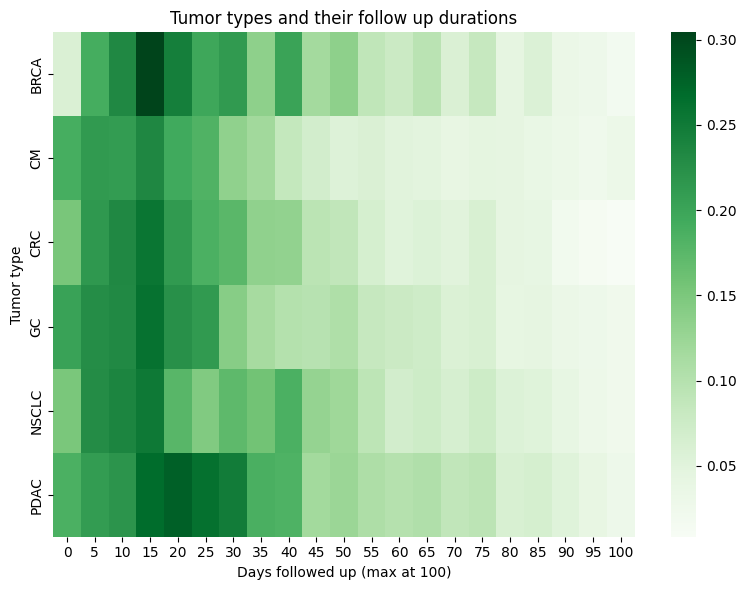

In [8]:
ct = pd.crosstab(pdx_response_data["Tumor Type"], pdx_response_data["Days Post T0"])
# ct = ct / ct.loc[:, 0]
ct_norm = ct.div(ct[0], axis=0)
ct_norm.drop(0, axis=1, inplace=True)
ct_norm.drop(ct_norm.columns[-1], axis=1, inplace=True)

# Define uniform follow-up days
uniform_days = np.arange(0, 101, 5)  # 0, 5, 10, ..., 100

# Reindex columns to these uniform days and interpolate
ct_interp = ct_norm.T  # transpose to make Days the index
ct_interp = ct_interp.reindex(uniform_days).interpolate(method='linear', limit_direction='both')

# (Optional) Rolling average smooth (window size = 3)
ct_smoothed = ct_interp.rolling(window=3, min_periods=1, center=True).mean()

# Transpose back: rows = tumor types, columns = Days
ct_final = ct_smoothed.T

# Plot heatmap
plt.figure(figsize = (8,6))
sns.heatmap(
    ct_final,
    cmap="Greens",          # white-to-green colormap
    linewidths=0,
    linecolor='gray',
    cbar=True,
    yticklabels=True       # hides row names
)

plt.xlabel("Days followed up (max at 100)")
plt.ylabel("Tumor type")              # optional: hides y-axis label
plt.title("Tumor types and their follow up durations")
plt.tight_layout()
plt.show()

As seen from above heatmap, many of the NSCLC samples were followed upto 20 days.

We now subset the data for erlotinib treated patients.

In [11]:
days_followup = list(range(0, 25, 5))
pdx_response_data = pdx_response_data.reset_index()
pdx_response_data["model_treatment"] = pdx_response_data["Model"].astype(str) + "_" + pdx_response_data["Treatment"]

# create a df for tumor volume difference over time
tumor_vol_shrinkage = pd.DataFrame(index = pdx_response_data["model_treatment"].unique(),
                                   columns = [f'T{i}' for i in days_followup])
# tumor_vol_shrinkage.head()
for model_treatment in list(pdx_response_data["model_treatment"].unique()):
  # print(model_treatment)
  model_data = pdx_response_data[pdx_response_data["model_treatment"] == model_treatment]
  # for 1st time point = 0
  if 0 in model_data["Days Post T0"]:
    tumor_vol_shrinkage.loc[model_treatment, "T0"] = model_data[model_data["Days Post T0"] == 0]["% TVol Difference"].values[0]
  for i, time_followup in enumerate(days_followup):
    if i != 0:
      # print(f"time:{time_followup}")
      if (model_data["Days Post T0"] < time_followup).any():
    # summarise based on time followup bins
        step_data = model_data[(model_data["Days Post T0"] != 0) & (model_data["Days Post T0"] > days_followup[i-1]) & (model_data["Days Post T0"] <= time_followup)]
        # print(step_data)
        tumor_vol_shrinkage.loc[model_treatment, f"T{time_followup}"] = np.mean(step_data["% TVol Difference"])

In [12]:
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20
X-007_BGJ398,0.0,191.8,293.6,396.5,NaN
X-007_BKM120,NaN,45.4,119.6,166.15,NaN
X-007_BYL719,NaN,187.0,294.0,303.7,NaN
X-007_BYL719 + HSP990,NaN,66.7,-11.7,6.1,33.45
X-007_BYL719 + LJM716,NaN,53.7,68.8,40.0,50.9


In [17]:
tumor_vol_shrinkage['Model'] = tumor_vol_shrinkage.index.str.split('_').str[0]
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model
X-007_BGJ398,0.0,191.8,293.6,396.5,NaN,X-007
X-007_BKM120,NaN,45.4,119.6,166.15,NaN,X-007
X-007_BYL719,NaN,187.0,294.0,303.7,NaN,X-007
X-007_BYL719 + HSP990,NaN,66.7,-11.7,6.1,33.45,X-007
X-007_BYL719 + LJM716,NaN,53.7,68.8,40.0,50.9,X-007


In [13]:
pdx_response_data.head()

,index,Model,Tumor Type,Treatment,Volume (mm3),body weight (g),Days Post T0,% TVol Difference,% BW Difference,model_treatment
0,0,X-007,GC,BGJ398,202.3,21.5,0,0.0,0.0,X-007_BGJ398
1,1,X-007,GC,BGJ398,590.3,23.0,4,191.8,7.0,X-007_BGJ398
2,2,X-007,GC,BGJ398,796.3,22.7,7,293.6,5.6,X-007_BGJ398
3,3,X-007,GC,BGJ398,1004.5,23.4,11,396.5,8.8,X-007_BGJ398
4,4,X-007,GC,BKM120,288.8,20.4,0,0.0,0.0,X-007_BKM120


In [15]:
pdx_response_data['Treatment'].value_counts()

Treatment
LEE011         3824
binimetinib    3786
BYL719         3475
BKM120         3385
CLR457         3363
               ... 
dacarbazine     331
erlotinib       325
LGH447          321
LDK378          270
LDE225          232
Name: count, Length: 62, dtype: int64

In [16]:
egfr_therapy = pdx_response_data[pdx_response_data['Treatment'] == 'erlotinib']
egfr_therapy.head()

,index,Model,Tumor Type,Treatment,Volume (mm3),body weight (g),Days Post T0,% TVol Difference,% BW Difference,model_treatment
11552,11552,X-1156,NSCLC,erlotinib,241.4,26.1,0,0.0,0.0,X-1156_erlotinib
11553,11553,X-1156,NSCLC,erlotinib,389.5,26.5,3,61.4,1.5,X-1156_erlotinib
11554,11554,X-1156,NSCLC,erlotinib,729.3,25.3,7,202.1,-3.1,X-1156_erlotinib
11555,11555,X-1156,NSCLC,erlotinib,733.3,23.6,10,203.8,-9.6,X-1156_erlotinib
11556,11556,X-1156,NSCLC,erlotinib,687.5,26.8,13,184.8,2.7,X-1156_erlotinib


In [18]:
egfr_treated_pt = egfr_therapy['Model'].unique()
tumor_vol_shrinkage = tumor_vol_shrinkage[tumor_vol_shrinkage['Model'].isin(egfr_treated_pt)]
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model
X-1156_BGJ398,NaN,27.5,106.3,166.1,246.5,X-1156
X-1156_BKM120,NaN,24.7,173.6,194.1,422.75,X-1156
X-1156_BKM120 + binimetinib,NaN,52.1,60.6,111.7,130.0,X-1156
X-1156_BYL719 + LGH447,NaN,-4.4,43.95,65.2,127.35,X-1156
X-1156_BYL719 + LJM716,NaN,6.3,147.75,339.8,502.35,X-1156


In [19]:
tumor_vol_shrinkage['therapy'] = tumor_vol_shrinkage.index.str.split("_").str[1]
tumor_vol_shrinkage = tumor_vol_shrinkage[tumor_vol_shrinkage['therapy'] == 'erlotinib']
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model,therapy
X-1156_erlotinib,NaN,61.4,202.95,184.8,391.7,X-1156,erlotinib
X-1172_erlotinib,NaN,-0.6,74.0,172.05,NaN,X-1172,erlotinib
X-1189_erlotinib,NaN,10.9,-4.05,-5.6,-49.3,X-1189,erlotinib
X-1228_erlotinib,NaN,-53.6,-54.1,-44.1,-38.3,X-1228,erlotinib
X-1323_erlotinib,NaN,-18.6,-18.9,27.6,57.2,X-1323,erlotinib


In [20]:
tumor_vol_shrinkage.set_index('Model', inplace=True, drop = True)
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,therapy
Model,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib
X-1189,NaN,10.9,-4.05,-5.6,-49.3,erlotinib
X-1228,NaN,-53.6,-54.1,-44.1,-38.3,erlotinib
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib


In [23]:
common_samples = np.intersect1d(pdx_exp.columns, tumor_vol_shrinkage.index)
pdx_exp = pdx_exp[common_samples].T
tumor_vol_shrinkage = tumor_vol_shrinkage.loc[common_samples]
pdx_exp.head()

Gene,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1156,3.005249,7.281283,-1.639646,3.210545,4.650691,6.748086,2.435532,7.081956,5.601510,4.931941,...,4.558227,2.391692,-1.515199,0.603942,4.343536,3.205128,6.053045,6.192540,4.338046,6.400886
X-1172,-4.510299,8.199078,-9.795701,2.900614,4.776703,6.992010,3.444643,6.000871,5.484526,5.507972,...,4.580492,2.702899,0.757928,2.187649,6.097245,3.594871,5.025126,2.308570,5.360105,7.030090
X-1323,1.385048,2.055912,-2.658953,1.439174,3.821155,6.873149,2.658093,6.496390,10.675614,3.834200,...,4.350460,2.699867,-6.646014,-2.945574,4.466891,3.996425,5.619894,5.709141,6.412244,7.438736
X-1442,-4.503718,9.149474,-9.789121,-0.206038,5.137222,7.180322,4.100859,5.800267,5.486677,4.103327,...,5.167755,2.745912,-2.001218,0.855637,4.287445,2.956764,5.463212,4.122927,5.695482,6.460715
X-1499,1.052644,3.324142,-1.561348,3.703661,5.532454,5.966648,1.564468,6.064549,7.054947,5.034771,...,4.656377,3.382977,-1.131723,0.741690,4.285739,4.397067,5.701498,5.039452,4.644667,6.583062


For the PDX dataset, L=30 gave the best results

In [24]:
gene_weights = pd.read_csv('/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/latent_30_validation/latent30_gene_weights.csv',
                           header = 0, index_col = 0)
gene_weights.head()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight
EGFR,0.360948,0.005513,2.332825,1.599903
KLK7,-0.094738,0.000341,-0.578267,-0.389472
SLC4A2,0.283241,-0.004950,1.775886,1.219304
PKMP1,0.386586,-0.010572,2.393172,1.641143
TINAGL1,0.087799,0.001058,0.579290,0.401576


In [25]:
common_genes = np.intersect1d(gene_weights.index, pdx_exp.columns)
print(len(common_genes))

131


In [26]:
weighted_df = pd.DataFrame(index = pdx_exp.index, columns = common_genes)
for gene in common_genes:
  g_weight = gene_weights.loc[gene, 'scaled_combined_weight']
  weighted_df[gene] = pdx_exp[gene] * g_weight
  
weighted_df.head()

,ACE2,ADAP1,AGPAT1,AGR2,AKT1S1,ALS2CL,ANKRD52,ANKS3,ANO1,BTBD19,...,TNK1,TNS4,TSPAN1,TUBB3,TXNDC15,UPK2,UPK3B,WFS1,ZNF668,ZNF750
X-1156,1.109995,5.178126,-8.059616,0.917855,8.554780,1.121371,0.374510,-1.136350,1.627558,0.312073,...,-0.511368,-0.446089,0.272740,3.960458,-3.147449,-7.288847,-2.589106,6.998383,0.078118,-1.576593
X-1172,0.022361,3.776295,-8.336472,1.317849,8.285291,0.534245,0.493949,-0.856189,-0.398875,-0.310752,...,-0.800811,5.196532,0.214786,2.271364,-2.886373,-5.433834,-2.060552,6.065759,0.130760,-1.755470
X-1323,-0.532865,5.926129,-7.369263,0.940772,6.524098,1.573349,0.522464,-1.031007,1.940870,-0.355252,...,-1.439598,-3.620674,-0.440069,4.173522,-2.026776,-1.834327,9.328709,5.002944,0.140039,0.206301
X-1442,-2.282623,7.583191,-9.594029,0.964012,8.046020,2.184616,0.500398,-0.966817,4.329471,-0.350832,...,-1.111426,-4.204348,-0.166728,0.777729,-2.824520,-15.073320,-4.671344,4.713357,0.141203,-1.568426
X-1499,1.132458,1.121912,-11.066827,0.072335,6.763767,1.555414,0.592963,-0.900069,1.102703,-1.056417,...,-0.331821,2.313073,0.090559,5.743317,-2.552585,1.812928,-1.248194,6.144318,0.081603,-0.269433


In [28]:
pdx_scores = weighted_df.sum(axis = 1)
# pdx_scores

In [29]:
tumor_vol_shrinkage['pdx_score'] = pdx_scores
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,therapy,pdx_score
Model,,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib,6.295068
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib,18.600258
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib,33.944110
X-1442,NaN,-10.4,-3.0,13.6,NaN,erlotinib,23.971205
X-1499,NaN,10.6,93.2,302.45,NaN,erlotinib,-9.162663


In [30]:
tumor_vol_shrinkage['score_cat'] = np.where(tumor_vol_shrinkage['pdx_score'] > np.median(tumor_vol_shrinkage['pdx_score']),
                                            'high score', 'low score')
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,therapy,pdx_score,score_cat
Model,,,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib,6.295068,low score
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib,18.600258,high score
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib,33.944110,high score
X-1442,NaN,-10.4,-3.0,13.6,NaN,erlotinib,23.971205,high score
X-1499,NaN,10.6,93.2,302.45,NaN,erlotinib,-9.162663,low score


In [37]:
long_df_data = pd.melt(
    tumor_vol_shrinkage.reset_index(),  # ensure 'pdx_id' is a column, not index
    id_vars=['pdx_score', 'score_cat'],
    value_vars=['T15'],
    # var_name='timepoint',
    value_name='%TVC'
)
long_df_data.dropna(inplace=True)
long_df_data['%TVC'] = pd.to_numeric(long_df_data['%TVC'], errors='coerce')
long_df_data.head()

,pdx_score,score_cat,variable,%TVC
0,6.295068,low score,T15,184.80
1,18.600258,high score,T15,172.05
2,33.944110,high score,T15,27.60
3,23.971205,high score,T15,13.60
4,-9.162663,low score,T15,302.45


In [38]:
from scipy.stats import mannwhitneyu
group_high = long_df_data.loc[long_df_data['score_cat'] == 'high score', '%TVC'].dropna()
group_low  = long_df_data.loc[long_df_data['score_cat'] == 'low score',  '%TVC'].dropna()
ks_stat, p_value = mannwhitneyu(group_high, group_low, alternative='less')

print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4e}")

KS Statistic: 45.0000
P-value: 2.5176e-01


<Axes: xlabel='score_cat', ylabel='%TVC'>

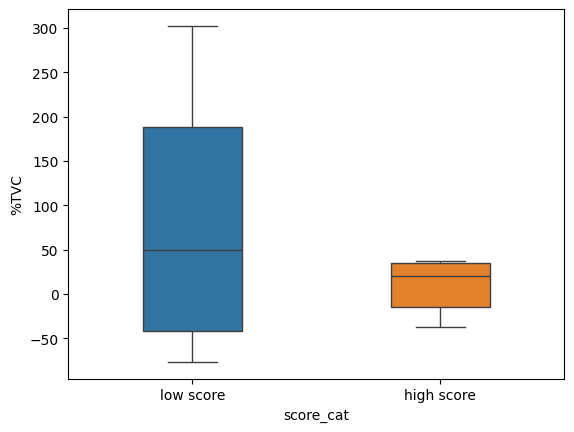

In [39]:
sns.boxplot(
    data=long_df_data,
    x="score_cat", y="%TVC",
    hue="score_cat", 
    showfliers=False,
    width=0.4  # <-- The main change here
)